In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_total = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [3]:
df1 = df_acc_total[["mergeid", "GGIR_mean_ENMO_total", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [4]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [5]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [6]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_bmi_num(df)
df = df.drop(df.loc[df['bmi'] < 15].index)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)


In [7]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [8]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [9]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

In [10]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, ax=None, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)

In [11]:
df[['Hypertension', 'Diabetes', 'OA']].value_counts() # check, that d group assoc still works

Hypertension  Diabetes  OA
0             0         0     379
1             0         0     238
              1         0      65
0             0         1      47
1             0         1      46
0             1         0      44
1             1         1      17
0             1         1       6
dtype: int64

In [12]:
df[['d1' ,'control']].value_counts() # check for target groups

d1  control
0   1          379
1   0          238
0   0          225
dtype: int64

In [13]:
groups = ["d1", "d2", "d3", "d4", "d5", "d6", "d7"]
categorie = [1,0,-1]

for g in groups:
    conditions = [
        (df[g] == 1) & (df['control'] == 0),
        (df['control'] == 1),
        (df[g] == 0) & (df['control'] == 0)
    ]
    df[f'{g}_strict'] = np.select(conditions,categorie,default=0)
    #df.drop(df.loc[df[f'{g}_strict'] == -1].index)

#df['d1_strict'] = np.select(conditions,categorie,default=0)
#df.drop(df.loc[df['d1_strict'] == -1].index)

In [14]:
df[['d1_strict', 'control']].value_counts() # identical to target groups -> works

d1_strict  control
 0         1          379
 1         0          238
-1         0          225
dtype: int64

run d1_strict: dropped 225 of 842 samples (73.3%)
run d2_strict: dropped 419 of 842 samples (50.2%)
run d3_strict: dropped 416 of 842 samples (50.6%)
run d4_strict: dropped 398 of 842 samples (52.7%)
run d5_strict: dropped 417 of 842 samples (50.5%)
run d6_strict: dropped 457 of 842 samples (45.7%)
run d7_strict: dropped 446 of 842 samples (47.0%)


'\n1) Nromal QQ-plot: Check normality of the residuals (should follow normal distribution)\n     -> slightly S-formed, might indicate the relationships are not actually linear.\n\n2) Homoscedasticity (Error is constant along the dependent variable)\n    -> not true. Different approach for categorical features e.g. random forest \n'

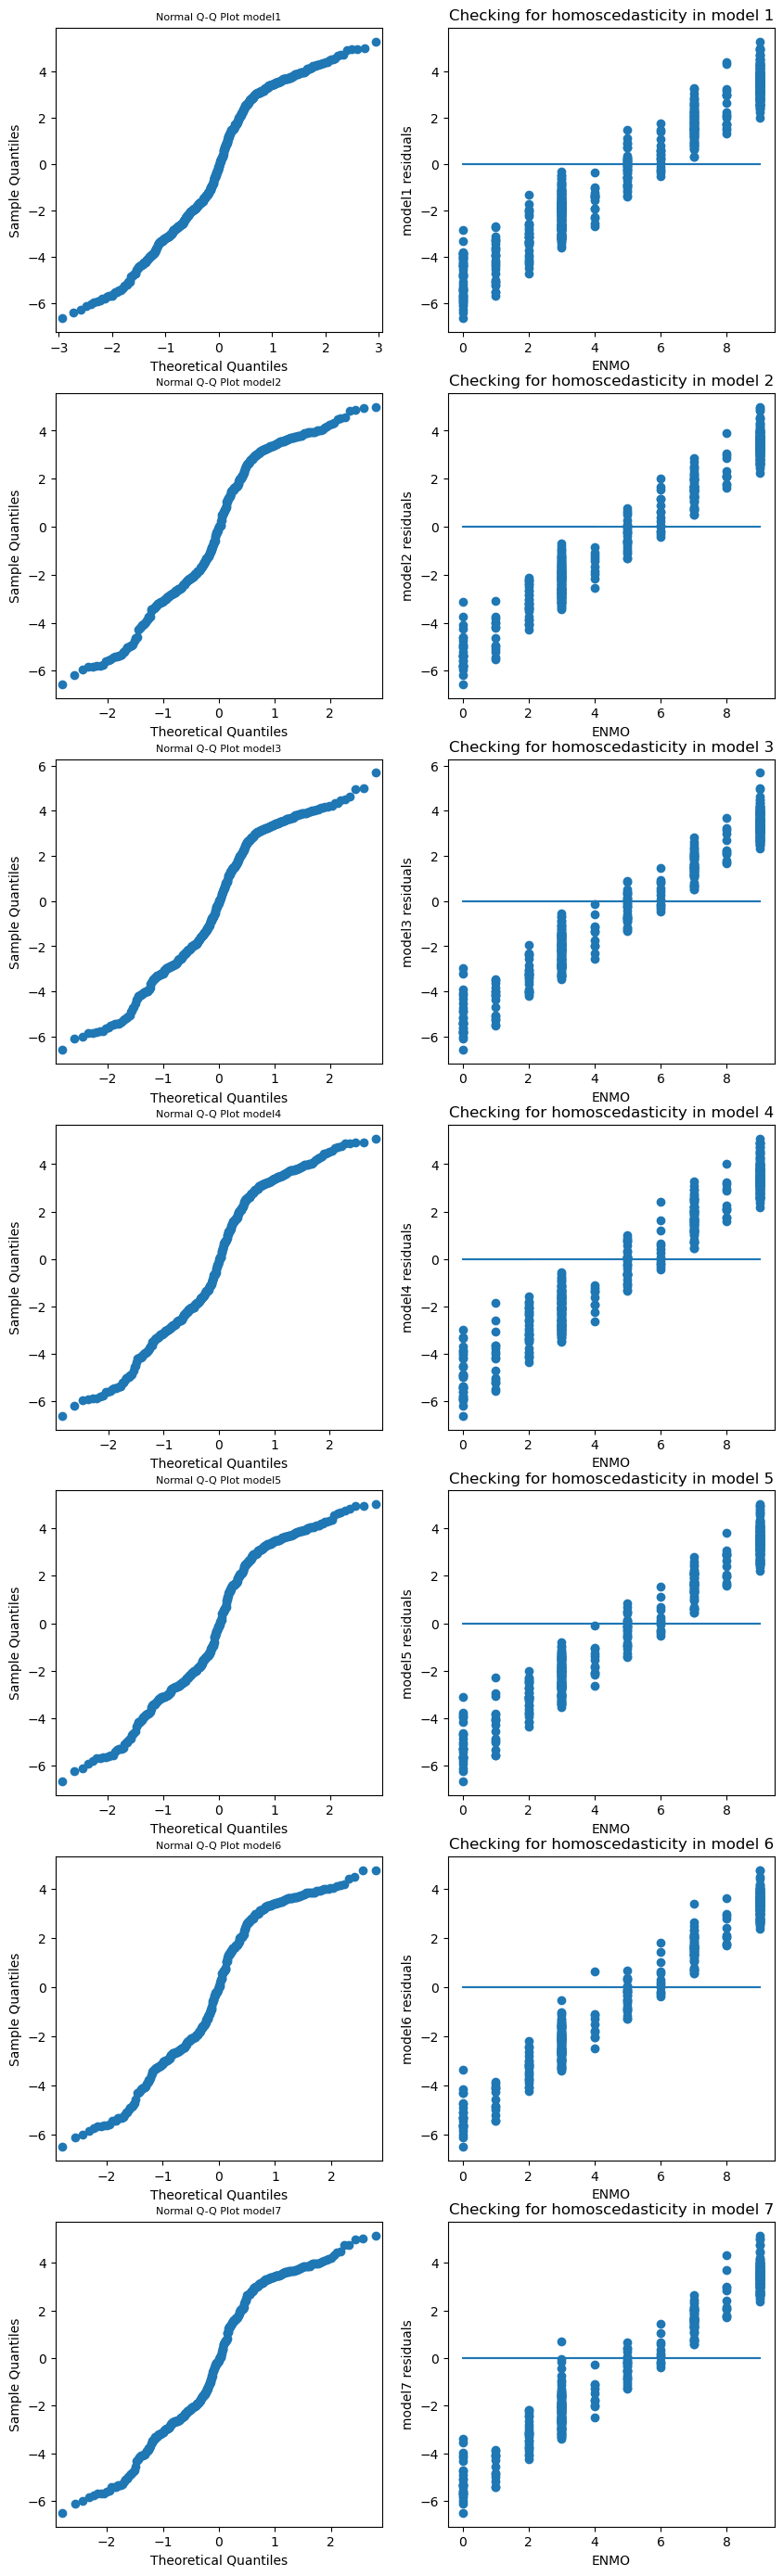

In [15]:
fig, ax = plt.subplots(7,2, figsize=(10,35))
result = pd.DataFrame()
vif = []

for i, g in enumerate(groups):
    g = f'{g}_strict'
    _df = df.drop(df.loc[df[g] == -1].index)
    
    # print # of dropped samples -> should match -1 samples from above. does -> works
    print(f'run {g}: dropped {len(df)- len(_df)} of {len(df)} samples ({len(_df)/len(df):.1%})') 
    
    _YVar = _df["activity"] #dependent

    _XVar = _df[[g, "age", "female", "bmi"]] #independent
    _XVar1 = sm.add_constant(_XVar)
    _model = sm.OLS(_YVar, _XVar1).fit()
    #_models = models.append(_model)
    as_html =_model.summary(slim=True).tables[1].as_html() 
    res = pd.read_html(as_html, header=0, index_col=0)[0]

    residuals = _model.resid
    sm.qqplot(residuals, ax=ax[i,0])
    ax[i,0].set_title(f"Normal Q-Q Plot model{i+1}",fontsize=8)

    ax[i,1].scatter(_YVar,residuals)
    ax[i,1].set_xlabel("ENMO")
    ax[i,1].set_ylabel(f"model{i+1} residuals")
    ax[i,1].set_title(f"Checking for homoscedasticity in model {i+1}")
    ax[i,1].plot(_YVar, [0]*len(_YVar))

    _vif = pd.DataFrame()
    _vif["VIF Factor"] = [variance_inflation_factor(_XVar1.values, i) for i in range(_XVar1.shape[1])]
    _vif["features"] = _XVar1.columns
    _vif.round(1)
    vif.append(_vif)

    result = pd.concat([result, res])
vif = pd.concat(vif)

'''
1) Nromal QQ-plot: Check normality of the residuals (should follow normal distribution)
     -> slightly S-formed, might indicate the relationships are not actually linear.

2) Homoscedasticity (Error is constant along the dependent variable)
    -> not true. Different approach for categorical features e.g. random forest 
'''

In [16]:
result.reset_index().groupby(by='index').mean() # mean performance across regressions

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,-0.061986,0.017000,-3.661857,0.001000,-0.095857,-0.028286
bmi,-0.048200,0.034857,-1.429857,0.210714,-0.116857,0.020429
const,11.269971,1.603000,7.104571,0.000000,8.119429,14.420286
d1_strict,-0.025500,0.266000,-0.096000,0.924000,-0.548000,0.497000
d2_strict,-0.362200,0.490000,-0.739000,0.460000,-1.325000,0.601000
d3_strict,-0.332700,0.470000,-0.707000,0.480000,-1.257000,0.592000
d4_strict,-0.767800,0.432000,-1.779000,0.076000,-1.616000,0.081000
d5_strict,-0.183500,0.496000,-0.370000,0.712000,-1.159000,0.792000
d6_strict,-1.215700,1.234000,-0.985000,0.325000,-3.642000,1.211000


In [17]:
result.reset_index().groupby(by='index').var() # check var to make sure constants are stable (age, bmi, ..) -> they are

,coef,std err,t,P>|t|,[0.025,0.975]
index,,,,,,
age,0.000035,0.000002,0.385190,0.000002,0.000024,0.000060
bmi,0.000251,0.000011,0.418708,0.017955,0.000119,0.000472
const,0.482271,0.016589,1.175490,0.000000,0.843545,0.250053
d1_strict,NaN,NaN,NaN,NaN,NaN,NaN
d2_strict,NaN,NaN,NaN,NaN,NaN,NaN
d3_strict,NaN,NaN,NaN,NaN,NaN,NaN
d4_strict,NaN,NaN,NaN,NaN,NaN,NaN
d5_strict,NaN,NaN,NaN,NaN,NaN,NaN
d6_strict,NaN,NaN,NaN,NaN,NaN,NaN


Linearity

Text(0.5, 1.0, 'female')

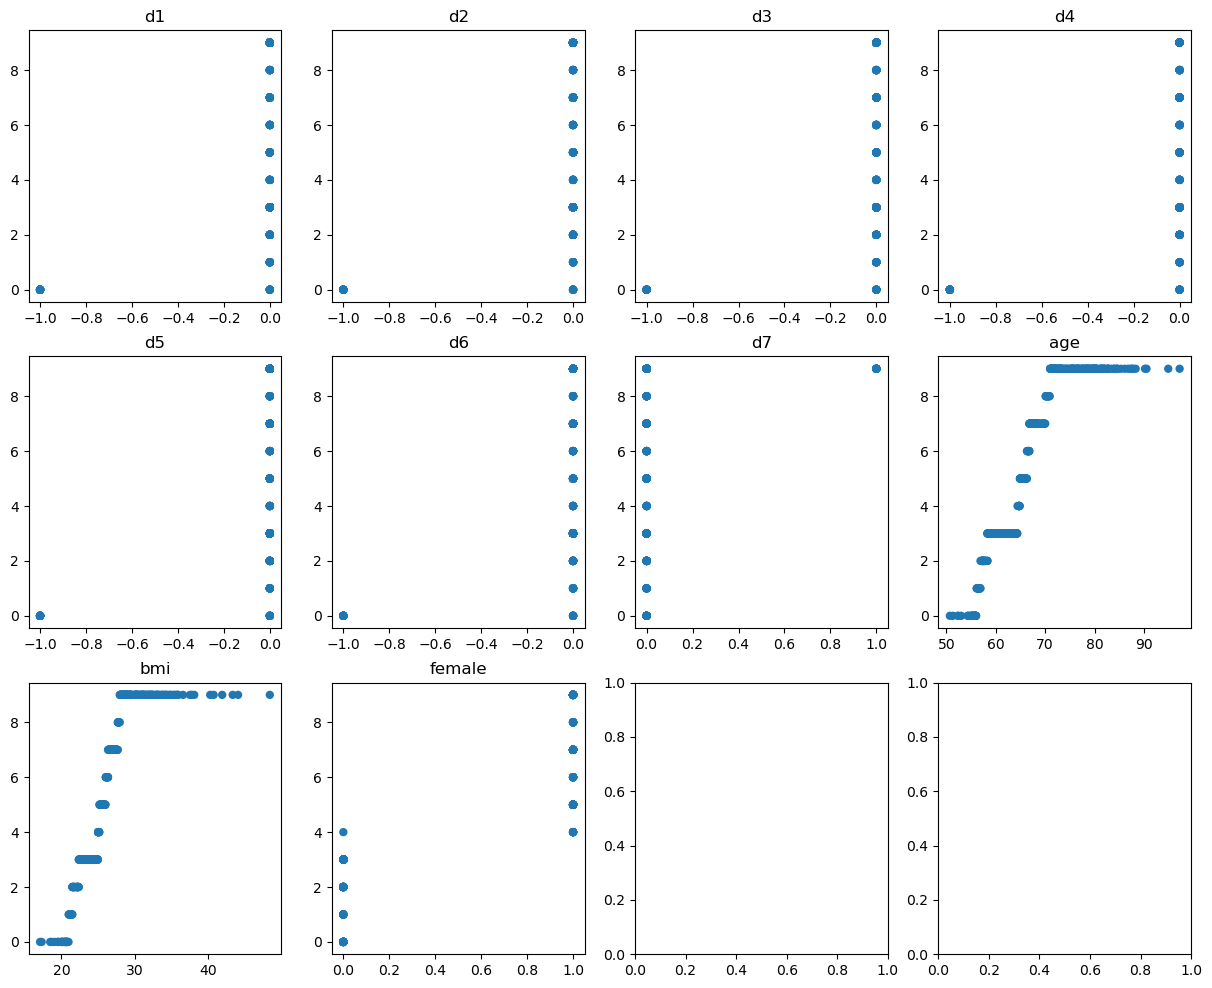

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
qqplot(_df['d1_strict'],_df["activity"], ax=ax[0,0])
ax[0,0].set_title("d1")
qqplot(_df['d2_strict'],_df["activity"], ax=ax[0,1])
ax[0,1].set_title("d2")
qqplot(_df['d3_strict'],_df["activity"], ax=ax[0,2])
ax[0,2].set_title("d3")
qqplot(_df['d4_strict'],_df["activity"], ax=ax[0,3])
ax[0,3].set_title("d4")
qqplot(_df['d5_strict'],_df["activity"], ax=ax[1,0])
ax[1,0].set_title("d5")
qqplot(_df['d6_strict'],_df["activity"], ax=ax[1,1])
ax[1,1].set_title("d6")
qqplot(_df['d7_strict'],_df["activity"], ax=ax[1,2])
ax[1,2].set_title("d7")
qqplot(_df['age'],_df["activity"], ax=ax[1,3])
ax[1,3].set_title("age")
qqplot(_df['bmi'],_df["activity"], ax=ax[2,0])
ax[2,0].set_title("bmi")
qqplot(_df['female'],_df["activity"], ax=ax[2,1])
ax[2,1].set_title("female")

Normality of the residuals (should follow normal distribution)

-> slightly S-formed, might indicate the relationships are not actually linear.

Multicollinearity

In [19]:
vif # every feature as a vif factor close to 1 -> no multicollinearity

,VIF Factor,features
0,118.618887,const
1,1.139927,d1_strict
2,1.091243,age
3,1.012239,female
4,1.105287,bmi
0,126.526672,const
1,1.056545,d2_strict
2,1.054067,age
3,1.025992,female
4,1.055516,bmi


Regression - self-reported activity

In [20]:
data_crosstab = pd.crosstab(df['disease'], df['activity'],margins=True, margins_name="Total")

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
rows = df['disease'].unique()
columns = df['activity'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 83.3091689439446  and p value is: 0.04430138355451918
Null Hypothesis is rejected.


In [21]:
sed_t = 10 #mean = 3.6
LPA_t = 100 #mean household = 5.9-22.4; mean = 58.5 (self-paced-free-living walk)

conditions = [
    (df["GGIR_mean_ENMO_total"] <= sed_t),
    (df["GGIR_mean_ENMO_total"] > sed_t) & (df["GGIR_mean_ENMO_total"] <= LPA_t),
    (df["GGIR_mean_ENMO_total"] > LPA_t)
]

#behaviour = ["SED", "LPA", "MVPA"]
behaviour = [1,2,3]
df["behaviour"] = np.select(conditions, behaviour)
df["behaviour"].fillna(0)

0      2
1      2
2      2
3      2
4      2
      ..
850    2
851    2
852    2
854    2
855    2
Name: behaviour, Length: 842, dtype: int32

ENMO vs. self-reported activity level

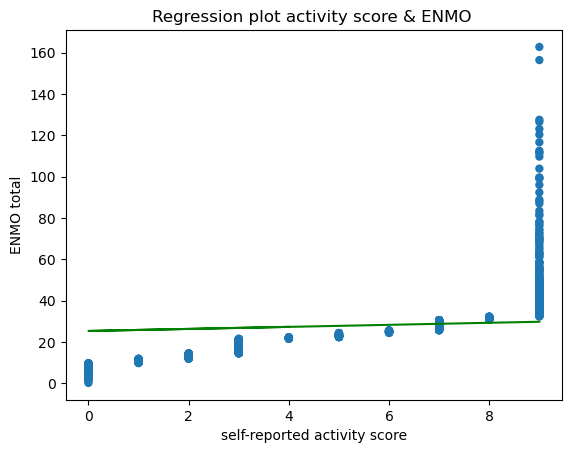

In [22]:
qqplot(df['activity'], df['GGIR_mean_ENMO_total'])
m, b = np.polyfit(df['activity'], df['GGIR_mean_ENMO_total'], 1)
plt.plot(df['activity'], m*df['activity']+b,color='green')
plt.title("Regression plot activity score & ENMO ")
plt.ylabel("ENMO total")
plt.xlabel("self-reported activity score")
plt.savefig(f'{dir_plots} ENMO Activity score Regression (QQ)')

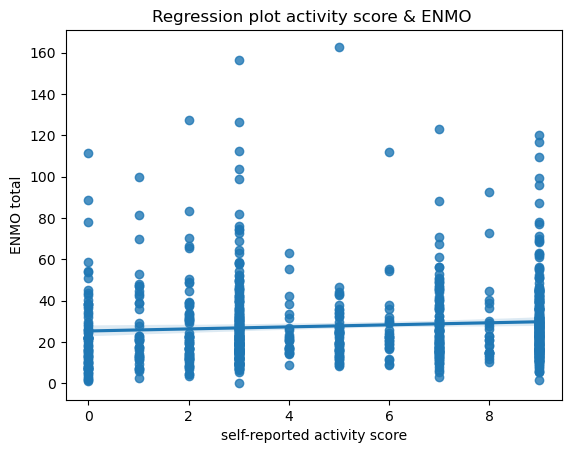

In [23]:
sns.regplot(data=df,x="activity",y="GGIR_mean_ENMO_total")
plt.title("Regression plot activity score & ENMO ")
plt.ylabel("ENMO total")
plt.xlabel("self-reported activity score")
plt.savefig(f'{dir_plots} ENMO Activity score Regression')

Regression ENMO total

In [24]:
df.loc[:, 'disease'] = df.replace({
    'd1': 1,
    'd2': 2,
    'd3': 3,
    'd4': 4,
    'd5': 5,
    'd6': 6,
    'd7': 7,
    'control': 8
    })

In [25]:
group = ["Hyp_Dia_OA", "control"]

YVar = df["GGIR_mean_ENMO_total"]

XVar1 = df[["disease", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
model = sm.OLS(YVar, XVar1).fit()
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     GGIR_mean_ENMO_total   R-squared:                       0.014
Model:                              OLS   Adj. R-squared:                  0.009
Method:                   Least Squares   F-statistic:                     2.901
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):             0.0211
Time:                          13:19:00   Log-Likelihood:                -3706.6
No. Observations:                   842   AIC:                             7423.
Df Residuals:                       837   BIC:                             7447.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.7741      7.944